# 吴恩达深度学习课程作业L2W6

* Improving Deep Neural Networks
* 加强深度网络性能的一些技巧
* 参数求解优化方法

## HW参考

1. [视频链接](https://mooc.study.163.com/university/deeplearning_ai#/c)
2. [作业链接](https://github.com/suqi/deeplearning_andrewng/tree/master/Course2-DL-tuning/week6)


## 优化方法简介

Gradient descent goes "downhill" on a cost function $J$. Think of it as trying to do this: 
<img src="./深度学习之吴恩达课程作业5/cost.jpg" style="width:650px;height:300px;">
<caption><center> <u> **Figure 1** </u>: **Minimizing the cost is like finding the lowest point in a hilly landscape**<br> At each step of the training, you update your parameters following a certain direction to try to get to the lowest possible point. </center></caption>

**Notations**: As usual, $\frac{\partial J}{\partial a } = $ `da` for any variable `a`.

## 导入模块

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
import math
import sklearn
import sklearn.datasets

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

## 数据生成模拟函数

In [2]:
def update_parameters_with_gd_test_case():
    np.random.seed(1)
    learning_rate = 0.01
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)

    dW1 = np.random.randn(2,3)
    db1 = np.random.randn(2,1)
    dW2 = np.random.randn(3,3)
    db2 = np.random.randn(3,1)
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    return parameters, grads, learning_rate

"""
def update_parameters_with_sgd_checker(function, inputs, outputs):
    if function(inputs) == outputs:
        print("Correct")
    else:
        print("Incorrect")
"""


def random_mini_batches_test_case():
    np.random.seed(1)
    mini_batch_size = 64
    X = np.random.randn(12288, 148)
    Y = np.random.randn(1, 148) < 0.5
    return X, Y, mini_batch_size


def initialize_velocity_test_case():
    np.random.seed(1)
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters


def update_parameters_with_momentum_test_case():
    np.random.seed(1)
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)

    dW1 = np.random.randn(2,3)
    db1 = np.random.randn(2,1)
    dW2 = np.random.randn(3,3)
    db2 = np.random.randn(3,1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    v = {'dW1': np.array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]), 'dW2': np.array([[ 0.,  0.,  0.],
        [ 0.,  0.,  0.],
        [ 0.,  0.,  0.]]), 'db1': np.array([[ 0.],
        [ 0.]]), 'db2': np.array([[ 0.],
        [ 0.],
        [ 0.]])}
    return parameters, grads, v


def initialize_adam_test_case():
    np.random.seed(1)
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    return parameters


def update_parameters_with_adam_test_case():
    np.random.seed(1)
    v, s = ({'dW1': np.array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]), 'dW2': np.array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]), 'db1': np.array([[ 0.],
         [ 0.]]), 'db2': np.array([[ 0.],
         [ 0.],
         [ 0.]])}, {'dW1': np.array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]), 'dW2': np.array([[ 0.,  0.,  0.],
         [ 0.,  0.,  0.],
         [ 0.,  0.,  0.]]), 'db1': np.array([[ 0.],
         [ 0.]]), 'db2': np.array([[ 0.],
         [ 0.],
         [ 0.]])})
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)

    dW1 = np.random.randn(2,3)
    db1 = np.random.randn(2,1)
    dW2 = np.random.randn(3,3)
    db2 = np.random.randn(3,1)
    
    parameters = {"W1": W1, "b1": b1, "W2": W2, "b2": b2}
    grads = {"dW1": dW1, "db1": db1, "dW2": dW2, "db2": db2}
    
    return parameters, grads, v, s

## 神经网络结构封装

### 激活函数

In [3]:
def func_sigmoid(Z):
    """
    Implements the sigmoid activation in numpy
    
    Arguments:
    Z -- numpy array of any shape
    
    Returns:
    A -- output of sigmoid(z), same shape as Z
    cache -- returns Z as well, useful during backpropagation
    """
    
    A = 1/(1+np.exp(-Z))
    cache = Z
    
    return A, cache

def func_relu(Z):
    """
    Implement the RELU function.

    Arguments:
    Z -- Output of the linear layer, of any shape

    Returns:
    A -- Post-activation parameter, of the same shape as Z
    cache -- a python dictionary containing "A" ; stored for computing the backward pass efficiently
    """
    
    A = np.maximum(0,Z)
    
    assert(A.shape == Z.shape)
    
    cache = Z 
    return A, cache


def func_relu_backward(dA, cache):
    """
    Implement the backward propagation for a single RELU unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    dZ = np.array(dA, copy=True) # just converting dz to a correct object.
    
    # When z <= 0, you should set dz to 0 as well. 
    dZ[Z <= 0] = 0
    
    assert (dZ.shape == Z.shape)
    
    return dZ

def func_sigmoid_backward(dA, cache):
    """
    Implement the backward propagation for a single SIGMOID unit.

    Arguments:
    dA -- post-activation gradient, of any shape
    cache -- 'Z' where we store for computing backward propagation efficiently

    Returns:
    dZ -- Gradient of the cost with respect to Z
    """
    
    Z = cache
    
    s = 1/(1+np.exp(-Z))
    dZ = dA * s * (1-s)
    
    assert (dZ.shape == Z.shape)
    
    return dZ

### 参数初始化

In [4]:
def func_L_layers_initialize_parameters(layer_dims, seed=1):
    """
    L层神经网络参数初始化
    :param layer_dims: python array (list) containing the dimensions of each layer in our network
    :param seed: 随机种子
    :return: 
        parameters -- python dictionary containing your parameters "W1", "b1", ..., "WL", "bL":
        Wl -- weight matrix of shape (layer_dims[l], layer_dims[l-1])
        bl -- bias vector of shape (layer_dims[l], 1)
    """
    np.random.seed(seed)
    parameters = {}
    L = len(layer_dims)
    
    # 这里/ np.sqrt(layer_dims[layer-1])很重要，如果还是*0.01，会导致模型cost降不下去
    for layer in range(1, L):
#         parameters['W' + str(layer)] = np.random.randn(layer_dims[layer], layer_dims[layer-1]) / np.sqrt(layer_dims[layer-1]) # * 0.01
        # todo he initialize
        parameters['W' + str(layer)] = np.random.randn(layer_dims[layer], layer_dims[layer-1]) * np.sqrt(2 / layer_dims[layer-1]) # * 0.01
        parameters['b' + str(layer)] = np.zeros((layer_dims[layer], 1))
        
        assert(parameters['W' + str(layer)].shape == (layer_dims[layer], layer_dims[layer-1]))
        assert(parameters['b' + str(layer)].shape == (layer_dims[layer], 1))
    return parameters

### forward

In [5]:
def func_linear_forward(A, W, b):
    """
    linear forward
    :param A:
    :param W:
    :param b:
    :return Z,chche:
        Z -- the input of the activation function, also called pre-activation parameter 
        cache -- a python dictionary containing "A", "W" and "b" ; stored for computing the backward pass efficiently
    """
    Z = np.dot(W, A) + b
    
    assert(Z.shape == (W.shape[0], A.shape[1]))
    cache = (A, W, b)
    return Z, cache

def func_linear_activation_forward(A_prev, W, b, activation):
    """
    Implement the forward propagation for the LINEAR->ACTIVATION layer
    :param A_prev: activations from previous layer (or input data): (size of previous layer, number of examples)
    :param W: weights matrix: numpy array of shape (size of current layer, size of previous layer)
    :param b: bias vector, numpy array of shape (size of the current layer, 1)
    :param activation: the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    :return:
        A -- the output of the activation function, also called the post-activation value 
        cache -- a python dictionary containing "linear_cache" and "activation_cache";
                 stored for computing the backward pass efficiently
    """
    Z, linear_cache = func_linear_forward(A_prev, W, b)
    if activation == 'sigmoid':
        A, activation_cache = func_sigmoid(Z)
    elif activation == 'relu':
        A, activation_cache = func_relu(Z)
    else:
        raise ValueError('activation param')
    
    assert(A.shape == (W.shape[0], A_prev.shape[1]))
    cache = (linear_cache, activation_cache)
    return A, cache

def func_L_model_forward(X, parameters):
    """
    Implement forward propagation for the [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID computation
    
    :param X -- data, numpy array of shape (input size, number of examples)
    :param parameters -- output of initialize_parameters_deep()
    
    :return:
        AL -- last post-activation value
        caches -- list of caches containing:
                    every cache of linear_relu_forward() (there are L-1 of them, indexed from 0 to L-2)
                    the cache of linear_sigmoid_forward() (there is one, indexed L-1)
    """
    caches = []
    A = X
    L = len(parameters) // 2
    
    for layer in range(1, L):
        A_prev = A
        W, b = parameters['W'+str(layer)], parameters['b'+str(layer)]
        A, cache = func_linear_activation_forward(A_prev, W, b, 'relu')
        caches.append(cache)
    
    A_prev = A
    layer = L
    W, b = parameters['W'+str(layer)], parameters['b'+str(layer)]
    A, cache = func_linear_activation_forward(A_prev, W, b, 'sigmoid')
    caches.append(cache)
    
    assert(A.shape == (1, X.shape[1]))
    return A, caches

### compute cost

In [6]:
def func_compute_cost(AL, Y):
    """
    Implement the cost function defined by equation (7).

    :param AL -- probability vector corresponding to your label predictions, shape (1, number of examples)
    :param Y -- true "label" vector (for example: containing 0 if non-cat, 1 if cat), shape (1, number of examples)

    :return:
        cost -- cross-entropy cost
    """
    m = Y.shape[1]
    
    # todo RuntimeWarning: divide by zero encountered in log
    AL = np.clip(AL, 1e-10, 1-1e-10)
    
#     Compute loss from aL and y.

#     logprobs = np.multiply(-np.log(AL), Y) + np.multiply(-np.log(1 - AL), 1 - Y)
#     cost = 1./m * np.nansum(logprobs)

#     cost = -1 / m * np.sum(np.multiply(Y, np.log(AL))+np.multiply(1-Y, np.log(1-AL)))
    cost = (1./m) * (-np.dot(Y,np.log(AL).T) - np.dot(1-Y, np.log(1-AL).T))
    
    cost = np.squeeze(cost)      # To make sure your cost's shape is what we expect (e.g. this turns [[17]] into 17).
    
    assert(cost.shape == ())
    return cost

### backward

In [7]:
def func_linear_backward(dZ, cache):
    """
    Implement the linear portion of backward propagation for a single layer (layer l)

    :param dZ -- Gradient of the cost with respect to the linear output (of current layer l)
    :param cache -- tuple of values (A_prev, W, b) coming from the forward propagation in the current layer

    :return:
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    A_prev, W, b = cache
    m = A_prev.shape[1]
    
    dW = 1. / m * np.dot(dZ, A_prev.T)
    db = 1. / m * np.sum(dZ, axis=1, keepdims=True)  # axis=1是行记录求和
    dA_prev = np.dot(W.T, dZ)
    
    assert(dW.shape == W.shape)
    assert(db.shape == b.shape)
    assert(dA_prev.shape == A_prev.shape)
    return dA_prev, dW, db

def func_linear_activation_backward(dA, cache, activation):
    """
    Implement the backward propagation for the LINEAR->ACTIVATION layer.
    
    :param dA -- post-activation gradient for current layer l 
    :param cache -- tuple of values (linear_cache, activation_cache) we store for computing backward propagation efficiently
    :param activation -- the activation to be used in this layer, stored as a text string: "sigmoid" or "relu"
    
    :returns
        dA_prev -- Gradient of the cost with respect to the activation (of the previous layer l-1), same shape as A_prev
        dW -- Gradient of the cost with respect to W (current layer l), same shape as W
        db -- Gradient of the cost with respect to b (current layer l), same shape as b
    """
    linear_cache, activation_cache = cache
    
    if activation == 'relu':
        dZ = func_relu_backward(dA, activation_cache)
    elif activation == 'sigmoid':
        dZ = func_sigmoid_backward(dA, activation_cache)
    else:
        raise ValueError('activation param')
    dA_prev, dW, db = func_linear_backward(dZ, linear_cache)
    return dA_prev, dW, db

def func_L_model_backward(AL, Y, caches):
    """
    Implement the backward propagation for the [LINEAR->RELU] * (L-1) -> LINEAR -> SIGMOID group
    
    :param AL -- probability vector, output of the forward propagation (L_model_forward())
    :param Y -- true "label" vector (containing 0 if non-cat, 1 if cat)
    :param caches -- list of caches containing:
                    every cache of linear_activation_forward() with "relu" (it's caches[l], for l in range(L-1) i.e l = 0...L-2)
                    the cache of linear_activation_forward() with "sigmoid" (it's caches[L-1])
    
    :return:
        grads -- A dictionary with the gradients
                 grads["dA" + str(l)] = ... 
                 grads["dW" + str(l)] = ...
                 grads["db" + str(l)] = ... 
    """
    grads = {}
    L = len(caches)
    m = AL.shape[1]
    Y = Y.reshape(AL.shape)
    
    # todo divide by zero encountered in true_divide
    dAL = - (np.divide(Y, AL, where=AL!=0) - np.divide(1-Y, 1-AL, where=(1-AL)!=0))
#     dAL = - (np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    
    cur_cache = caches[L-1]
    grads['dA' + str(L-1)], grads['dW'+str(L)], grads['db'+str(L)] = func_linear_activation_backward(dAL, cur_cache, activation='sigmoid')
    
    for layer in reversed(range(L-1)):
        cur_cache = caches[layer]
        dA_prev_tmp, dW_tmp, db_tmp = func_linear_activation_backward(grads["dA"+str(layer+1)], cur_cache, activation='relu')
        grads['dA'+str(layer)] = dA_prev_tmp
        grads['dW'+str(layer+1)] = dW_tmp
        grads['db'+str(layer+1)] = db_tmp
    
#     current_cache = caches[L-1]
#     grads["dA" + str(L)], grads["dW" + str(L)], grads["db" + str(L)] = func_linear_activation_backward(dAL, current_cache, activation = "sigmoid")
    
#     for l in reversed(range(L-1)):
#         # lth layer: (RELU -> LINEAR) gradients.
#         current_cache = caches[l]
#         dA_prev_temp, dW_temp, db_temp = func_linear_activation_backward(grads["dA" + str(l + 2)], current_cache, activation = "relu")
#         grads["dA" + str(l + 1)] = dA_prev_temp
#         grads["dW" + str(l + 1)] = dW_temp
#         grads["db" + str(l + 1)] = db_temp
    
    return grads

### update parameters

In [8]:
def func_update_parameters(parameters, grads, lr):
    """
    Update parameters using gradient descent
    
    :param parameters -- python dictionary containing your parameters 
    :param grads -- python dictionary containing your gradients, output of L_model_backward
    :param lr: learning rate
    :return:
        parameters -- python dictionary containing your updated parameters 
                      parameters["W" + str(l)] = ... 
                      parameters["b" + str(l)] = ...
    """
    L = len(parameters) // 2
    
    for layer in range(1, L+1):
        parameters['W'+str(layer)] = parameters['W'+str(layer)] - lr * grads['dW' + str(layer)]
        parameters['b'+str(layer)] = parameters['b'+str(layer)] - lr * grads['db' + str(layer)]
    
    return parameters

### predict

In [9]:
def func_predict(X, y, parameters):
    """
    This function is used to predict the results of a  L-layer neural network.
    
    :param X -- data set of examples you would like to label
    :param parameters -- parameters of the trained model
    :return:
        p -- predictions for the given dataset X
    """
    m = X.shape[1]
    L = len(parameters) // 2
    p = np.zeros((1, m))
    
    probas, caches = func_L_model_forward(X, parameters)
    
    for i in range(probas.shape[1]):
        if probas[0, i] > 0.5:
            p[0, i] = 1
        else:
            p[0, i] = 0
    
    print('acc: {}'.format(np.sum(p==y)/m))
    return p

### dnn model

In [10]:
def func_L_layer_dnn_model(X, Y, layer_dims, lr=0.001, num_epochs=10000, print_cost=False):
    """
    多层神经网络模型
    :param X:
    :param Y:
    :param layer_dims: python array (list) containing the dimensions of each layer in our network
    :param lr: learning rate
    :param num_epochs:
    :param print_cost:
    :return params
    """
    np.random.seed(1)
    costs = []
#     m = X.shape[1]
    
    # 参数初始化
    parameters = func_L_layers_initialize_parameters(layer_dims)
    
    # loop
    for epoch in range(num_epochs):
        # 前向传播
        AL, caches = func_L_model_forward(X, parameters)
        
        # 计算损失
        cost = func_compute_cost(AL, Y)
        
        # 后向传播
        grads = func_L_model_backward(AL, Y, caches)

        # 更新参数
        parameters = func_update_parameters(parameters, grads, lr)
        
        # 打印信息
        if print_cost and epoch % 100 == 0:
            print('cost after epoch {}: {}'.format(epoch, np.squeeze(cost)))
        if epoch % 100 == 0:
            costs.append(cost)
    
    return parameters, costs

## 其他通用函数

In [11]:
def func_load_params_and_grads(seed=1):
    np.random.seed(seed)
    W1 = np.random.randn(2,3)
    b1 = np.random.randn(2,1)
    W2 = np.random.randn(3,3)
    b2 = np.random.randn(3,1)

    dW1 = np.random.randn(2,3)
    db1 = np.random.randn(2,1)
    dW2 = np.random.randn(3,3)
    db2 = np.random.randn(3,1)
    
    return W1, b1, W2, b2, dW1, db1, dW2, db2


def func_load_2D_dataset():
    data = scipy.io.loadmat('./深度学习之吴恩达课程作业5/data.mat')
    train_X = data['X'].T
    train_Y = data['y'].T
    test_X = data['Xval'].T
    test_Y = data['yval'].T

    plt.scatter(train_X[0, :], train_X[1, :], c=train_Y, s=40, cmap=plt.cm.Spectral);
    
    return train_X, train_Y, test_X, test_Y


def func_plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()


def func_predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    AL, cache = func_L_model_forward(X, parameters)
    predictions = (AL>0.5)
    return predictions


def func_load_dataset():
    np.random.seed(3)
    train_X, train_Y = sklearn.datasets.make_moons(n_samples=300, noise=.2) #300 #0.2 
    # Visualize the data
    plt.scatter(train_X[:, 0], train_X[:, 1], c=train_Y, s=40, cmap=plt.cm.Spectral);
    train_X = train_X.T
    train_Y = train_Y.reshape((1, train_Y.shape[0]))
    
    return train_X, train_Y


def func_plot_cost(costs, lr):
    """
    plot cost
    :param costs: 
    """
    # plot the cost
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('epochs (per 100)')
    plt.title("Learning rate = " + str(lr))
    plt.show()

## 梯度下降

### batch gradient descent=全量梯度下降
* When you take gradient steps with respect to all `m` examples on each step, it is also called `Batch Gradient Descent`
* 参数更新公式
$$
W^{[l]} = W^{[l]} - \alpha \text{ } dW^{[l]} \\
b^{[l]} = b^{[l]} - \alpha \text{ } db^{[l]}
$$

#### overwrite update parameters

In [12]:
def func_update_parameters_with_gd(parameters, grads, lr):
    """
    Update parameters using one step of gradient descent
    
    :param parameters -- python dictionary containing your parameters 
    :param grads -- python dictionary containing your gradients, output of L_model_backward
    :param lr: learning rate
    :return:
        parameters -- python dictionary containing your updated parameters 
                      parameters["W" + str(l)] = ... 
                      parameters["b" + str(l)] = ...
    """
    L = len(parameters) // 2
    
    for layer in range(1, L+1):
        parameters['W'+str(layer)] = parameters['W'+str(layer)] - lr * grads['dW' + str(layer)]
        parameters['b'+str(layer)] = parameters['b'+str(layer)] - lr * grads['db' + str(layer)]
    
    return parameters

In [13]:
parameters, grads, lr = update_parameters_with_gd_test_case()
parameters, grads, lr

({'W1': array([[ 1.62434536, -0.61175641, -0.52817175],
         [-1.07296862,  0.86540763, -2.3015387 ]]),
  'b1': array([[ 1.74481176],
         [-0.7612069 ]]),
  'W2': array([[ 0.3190391 , -0.24937038,  1.46210794],
         [-2.06014071, -0.3224172 , -0.38405435],
         [ 1.13376944, -1.09989127, -0.17242821]]),
  'b2': array([[-0.87785842],
         [ 0.04221375],
         [ 0.58281521]])},
 {'dW1': array([[-1.10061918,  1.14472371,  0.90159072],
         [ 0.50249434,  0.90085595, -0.68372786]]),
  'db1': array([[-0.12289023],
         [-0.93576943]]),
  'dW2': array([[-0.26788808,  0.53035547, -0.69166075],
         [-0.39675353, -0.6871727 , -0.84520564],
         [-0.67124613, -0.0126646 , -1.11731035]]),
  'db2': array([[0.2344157 ],
         [1.65980218],
         [0.74204416]])},
 0.01)

In [14]:
parameters = func_update_parameters_with_gd(parameters, grads, lr)
parameters

{'W1': array([[ 1.63535156, -0.62320365, -0.53718766],
        [-1.07799357,  0.85639907, -2.29470142]]),
 'b1': array([[ 1.74604067],
        [-0.75184921]]),
 'W2': array([[ 0.32171798, -0.25467393,  1.46902454],
        [-2.05617317, -0.31554548, -0.3756023 ],
        [ 1.1404819 , -1.09976462, -0.1612551 ]]),
 'b2': array([[-0.88020257],
        [ 0.02561572],
        [ 0.57539477]])}

### mini batch gradient descent=小批量梯度下降

* 步骤
    1. **Shuffle**: Create a shuffled version of the training set (X, Y) as shown below. Each column of X and Y represents a training example. Note that the random shuffling is done synchronously between X and Y. Such that after the shuffling the $i^{th}$ column of X is the example corresponding to the $i^{th}$ label in Y. The shuffling step ensures that examples will be split randomly into different mini-batches. 
    
    <img src="./深度学习之吴恩达课程作业5/kiank_shuffle.png" style="width:550px;height:300px;">

    2. **Partition**: Partition the shuffled (X, Y) into mini-batches of size `mini_batch_size` (here 64). Note that the number of training examples is not always divisible by `mini_batch_size`. The last mini batch might be smaller, but you don't need to worry about this. When the final mini-batch is smaller than the full `mini_batch_size`, it will look like this: 

    <img src="./深度学习之吴恩达课程作业5/kiank_partition.png" style="width:550px;height:300px;">

* 注意：最后一个batch可能不满batch_size

#### 构建 random_mini_batches函数

In [15]:
def func_random_mini_batches(X, Y, batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)
    
    :param X -- input data, of shape (input size, number of examples)
    :param Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    :param batch_size -- size of the mini-batches, integer
    :return mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    np.random.seed(seed)
    m = X.shape[1]
    mini_batches = []
    
    # step 1: shuffle
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((1, m))
    
    # step 2: partition
    num_complete_minibatches = math.floor(m / batch_size)
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k*batch_size: (k+1)*batch_size]
        mini_batch_Y = shuffled_Y[:, k*batch_size: (k+1)*batch_size]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    if m % batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches*batch_size:]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches*batch_size:]
        
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    return mini_batches

In [16]:
X_assess, Y_assess, mini_batch_size = random_mini_batches_test_case()
mini_batches = func_random_mini_batches(X_assess, Y_assess, mini_batch_size)

print ("shape of the 1st mini_batch_X: " + str(mini_batches[0][0].shape))
print ("shape of the 2nd mini_batch_X: " + str(mini_batches[1][0].shape))
print ("shape of the 3rd mini_batch_X: " + str(mini_batches[2][0].shape))
print ("shape of the 1st mini_batch_Y: " + str(mini_batches[0][1].shape))
print ("shape of the 2nd mini_batch_Y: " + str(mini_batches[1][1].shape)) 
print ("shape of the 3rd mini_batch_Y: " + str(mini_batches[2][1].shape))
print ("mini batch sanity check: " + str(mini_batches[0][0][0][0:3]))

shape of the 1st mini_batch_X: (12288, 64)
shape of the 2nd mini_batch_X: (12288, 64)
shape of the 3rd mini_batch_X: (12288, 20)
shape of the 1st mini_batch_Y: (1, 64)
shape of the 2nd mini_batch_Y: (1, 64)
shape of the 3rd mini_batch_Y: (1, 20)
mini batch sanity check: [ 0.90085595 -0.7612069   0.2344157 ]


### Stochastic Gradient Descent=随机梯度下降

A variant of this is Stochastic Gradient Descent (SGD), which is equivalent to mini-batch gradient descent where each mini-batch has just 1 example. The update rule that you have just implemented does not change. What changes is that you would be computing gradients on just one training example at a time, rather than on the whole training set. The code examples below illustrate the difference between stochastic gradient descent and (batch) gradient descent.

* 具体过程

```python
X = data_input
Y = labels
parameters = func_initialize_parameters(layer_dims)
m = X.shape[1]

for i in range(epochs):
    for j in range(m):
        a, caches = func_forward_propagation(X[:, j], parameters)  # 每次只用一个样本
        cost = func_compute_cost(a, Y[:, j])
        grads = func_backward_propagation(a, caches, parameters)
        parameters = func_update_parameters(parameters, grads)
```

In Stochastic Gradient Descent, you use only 1 training example before updating the gradients. When the training set is large, SGD can be faster. But the parameters will "oscillate"(振荡) toward the minimum rather than converge smoothly. Here is an illustration of this:

<img src="./深度学习之吴恩达课程作业5/kiank_sgd.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 1** </u><font color='purple'>  : **SGD vs GD**<br> "+" denotes a minimum of the cost. SGD leads to many oscillations to reach convergence. But each step is a lot faster to compute for SGD than for GD, as it uses only one training example (vs. the whole batch for GD). </center></caption>

**Note** also that implementing SGD requires 3 for-loops in total:
1. Over the number of iterations
2. Over the $m$ training examples
3. Over the layers (to update all parameters, from $(W^{[1]},b^{[1]})$ to $(W^{[L]},b^{[L]})$)

In practice, you'll often get faster results if you do not use neither the whole training set, nor only one training example, to perform each update. Mini-batch gradient descent uses an intermediate number of examples for each step. With mini-batch gradient descent, you loop over the mini-batches instead of looping over individual training examples.

<img src="./深度学习之吴恩达课程作业5/kiank_minibatch.png" style="width:750px;height:250px;">
<caption><center> <u> <font color='purple'> **Figure 2** </u>: <font color='purple'>  **SGD vs Mini-Batch GD**<br> "+" denotes a minimum of the cost. Using mini-batches in your optimization algorithm often leads to faster optimization. </center></caption>

<font color='blue'>

**What you should remember**:
- The difference between gradient descent, mini-batch gradient descent and stochastic gradient descent is the number of examples you use to perform one update step.
- You have to tune a learning rate hyperparameter $\alpha$.
- With a well-turned mini-batch size, usually it outperforms either gradient descent or stochastic gradient descent (particularly when the training set is large).

选定一个良好的批量值，通常由于梯度下降和随机梯度下降

## 梯度下降with Momentum

Because mini-batch gradient descent makes a parameter update after seeing just a subset of examples, the direction of the update has some variance, and so the path taken by mini-batch gradient descent will "oscillate" toward convergence. Using momentum can reduce these oscillations.(用Momentum可以减小这样的振荡)

Momentum takes into account the past gradients to smooth out the update. We will store the 'direction' of the previous gradients in the variable $v$ (会考虑前面的梯度值). Formally, this will be the exponentially weighted average of the gradient on previous steps. You can also think of $v$ as the "velocity" of a ball rolling downhill, building up speed (and momentum) according to the direction of the gradient/slope of the hill. 

<img src="./深度学习之吴恩达课程作业5/opt_momentum.png" style="width:400px;height:250px;">
<caption><center> <u><font color='purple'>**Figure 3**</u><font color='purple'>: The red arrows shows the direction taken by one step of mini-batch gradient descent with momentum. The blue points show the direction of the gradient (with respect to the current mini-batch) on each step. Rather than just following the gradient, we let the gradient influence $v$ and then take a step in the direction of $v$.<br> <font color='black'> </center>

计算公式如下

The momentum update rule is, for $l = 1, ..., L$: 

$$ \begin{cases}
v_{dW^{[l]}} = \beta v_{dW^{[l]}} + (1 - \beta) dW^{[l]} \\
W^{[l]} = W^{[l]} - \alpha v_{dW^{[l]}}
\end{cases}\tag{3}$$

$$\begin{cases}
v_{db^{[l]}} = \beta v_{db^{[l]}} + (1 - \beta) db^{[l]} \\
b^{[l]} = b^{[l]} - \alpha v_{db^{[l]}} 
\end{cases}\tag{4}$$

where L is the number of layers, $\beta$ is the momentum and $\alpha$ is the learning rate. All parameters should be stored in the `parameters` dictionary.

**Note** that:
- The velocity is initialized with zeros. So the algorithm will take a few iterations to "build up" velocity and start to take bigger steps.
- If $\beta = 0$, then this just becomes standard gradient descent without momentum. 

**How do you choose $\beta$?**

- The larger the momentum $\beta$ is, the smoother the update because the more we take the past gradients into account. But if $\beta$ is too big, it could also smooth out the updates too much. 
- <font size=3 color=red>Common values for $\beta$ range from 0.8 to 0.999. If you don't feel inclined to tune this, $\beta = 0.9$ is often a reasonable default. </font>
- Tuning the optimal $\beta$ for your model might need trying several values to see what works best in term of reducing the value of the cost function $J$. 

<font color='blue'>

**What you should remember**:
- Momentum takes past gradients into account to smooth out the steps of gradient descent. It can be applied with batch gradient descent, mini-batch gradient descent or stochastic gradient descent.
- You have to tune a momentum hyperparameter $\beta$ and a learning rate $\alpha$.

### initialize velocity

In [17]:
def func_initialize_velocity(parameters):
    """
    initialize velocity
    :param parameters:
    :return v: python dictionary containing the current velocity.
                v['dW' + str(l)] = velocity of dWl
                v['db' + str(l)] = velocity of dbl
    """
    L = len(parameters) // 2
    v = {}
    
    for layer in range(1, L+1):
        # Return an array of zeros with the same shape and type as a given array
        v['dW' + str(layer)] = np.zeros_like(parameters['W' + str(layer)])
        v['db' + str(layer)] = np.zeros_like(parameters['b' + str(layer)])
    
    return v

In [18]:
parameters = initialize_velocity_test_case()
parameters

{'W1': array([[ 1.62434536, -0.61175641, -0.52817175],
        [-1.07296862,  0.86540763, -2.3015387 ]]),
 'b1': array([[ 1.74481176],
        [-0.7612069 ]]),
 'W2': array([[ 0.3190391 , -0.24937038,  1.46210794],
        [-2.06014071, -0.3224172 , -0.38405435],
        [ 1.13376944, -1.09989127, -0.17242821]]),
 'b2': array([[-0.87785842],
        [ 0.04221375],
        [ 0.58281521]])}

In [19]:
v = func_initialize_velocity(parameters)
v

{'dW1': array([[0., 0., 0.],
        [0., 0., 0.]]),
 'db1': array([[0.],
        [0.]]),
 'dW2': array([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]]),
 'db2': array([[0.],
        [0.],
        [0.]])}

### overwrite update parameters

In [20]:
def func_update_parameters_with_momentum(parameters, grads, v, beta, lr):
    """
    Update parameters using gradient descent
    
    :param parameters -- python dictionary containing your parameters 
    :param grads -- python dictionary containing your gradients, output of L_model_backward
    :param v -- python dictionary containing the current velocity
    :param beta -- the momentum hyperparameter, scalar
    :param lr: learning rate
    :return:
        parameters -- python dictionary containing your updated parameters 
                      parameters["W" + str(l)] = ... 
                      parameters["b" + str(l)] = ...
    """
    L = len(parameters) // 2
    
    for layer in range(1, L+1):
        v['dW' + str(layer)] = beta * v['dW' + str(layer)] + (1-beta) * grads['dW' + str(layer)]
        v['db' + str(layer)] = beta * v['db' + str(layer)] + (1-beta) * grads['db' + str(layer)]
        
        parameters['W'+str(layer)] = parameters['W'+str(layer)] - lr * v['dW' + str(layer)]
        parameters['b'+str(layer)] = parameters['b'+str(layer)] - lr * v['db' + str(layer)]
    
    return parameters, v

In [21]:
parameters, grads, v = update_parameters_with_momentum_test_case()
parameters, grads, v

({'W1': array([[ 1.62434536, -0.61175641, -0.52817175],
         [-1.07296862,  0.86540763, -2.3015387 ]]),
  'b1': array([[ 1.74481176],
         [-0.7612069 ]]),
  'W2': array([[ 0.3190391 , -0.24937038,  1.46210794],
         [-2.06014071, -0.3224172 , -0.38405435],
         [ 1.13376944, -1.09989127, -0.17242821]]),
  'b2': array([[-0.87785842],
         [ 0.04221375],
         [ 0.58281521]])},
 {'dW1': array([[-1.10061918,  1.14472371,  0.90159072],
         [ 0.50249434,  0.90085595, -0.68372786]]),
  'db1': array([[-0.12289023],
         [-0.93576943]]),
  'dW2': array([[-0.26788808,  0.53035547, -0.69166075],
         [-0.39675353, -0.6871727 , -0.84520564],
         [-0.67124613, -0.0126646 , -1.11731035]]),
  'db2': array([[0.2344157 ],
         [1.65980218],
         [0.74204416]])},
 {'dW1': array([[0., 0., 0.],
         [0., 0., 0.]]),
  'dW2': array([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
  'db1': array([[0.],
         [0.]]),
  'db2': array([[0.],

In [22]:
beta = 0.9
lr = 0.01
parameters, v = func_update_parameters_with_momentum(parameters, grads, v, beta, lr)
parameters

{'W1': array([[ 1.62544598, -0.61290114, -0.52907334],
        [-1.07347112,  0.86450677, -2.30085497]]),
 'b1': array([[ 1.74493465],
        [-0.76027113]]),
 'W2': array([[ 0.31930698, -0.24990073,  1.4627996 ],
        [-2.05974396, -0.32173003, -0.38320915],
        [ 1.13444069, -1.0998786 , -0.1713109 ]]),
 'b2': array([[-0.87809283],
        [ 0.04055394],
        [ 0.58207317]])}

## 梯度下降 with adam

Adam算法是训练神经网络最有效的优化算法之一。它结合了RMSProp和Momentum的想法

计算步骤如下：
1. It calculates an exponentially weighted average of past gradients, and stores it in variables $v$ (before bias correction) and $v^{corrected}$ (with bias correction). 
2. It calculates an exponentially weighted average of the squares of the past gradients, and  stores it in variables $s$ (before bias correction) and $s^{corrected}$ (with bias correction). 
3. It updates parameters in a direction based on combining information from "1" and "2".

计算公式如下：

$$
\begin{cases}
v_{dW^{[l]}} = \beta_1 v_{dW^{[l]}} + (1 - \beta_1) \frac{\partial \mathcal{J} }{ \partial W^{[l]} } \\
v^{corrected}_{dW^{[l]}} = \frac{v_{dW^{[l]}}}{1 - (\beta_1)^t} \\
s_{dW^{[l]}} = \beta_2 s_{dW^{[l]}} + (1 - \beta_2) (\frac{\partial \mathcal{J} }{\partial W^{[l]} })^2 \\
s^{corrected}_{dW^{[l]}} = \frac{s_{dW^{[l]}}}{1 - (\beta_1)^t} \\
W^{[l]} = W^{[l]} - \alpha \frac{v^{corrected}_{dW^{[l]}}}{\sqrt{s^{corrected}_{dW^{[l]}}} + \varepsilon}
\end{cases}
$$
where:
- t counts the number of steps taken of Adam 
- L is the number of layers
- $\beta_1$ and $\beta_2$ are hyperparameters that control the two exponentially weighted averages. 
- $\alpha$ is the learning rate
- $\varepsilon$ is a very small number to avoid dividing by zero

<font color='blue' size=3>

超参数一般设定：
1. $\beta_1$=0.9
2. $\beta_2$=0.999
3. $\varepsilon = 1e-10$
</font>

### initialize adam

In [23]:
def func_initialize_adam(parameters):
    """
    Initializes v and s as two python dictionaries with:
                - keys: "dW1", "db1", ..., "dWL", "dbL" 
                - values: numpy arrays of zeros of the same shape as the corresponding gradients/parameters.
    
    Arguments:
    parameters -- python dictionary containing your parameters.
                    parameters["W" + str(l)] = Wl
                    parameters["b" + str(l)] = bl
    
    Returns: 
    v -- python dictionary that will contain the exponentially weighted average of the gradient.
                    v["dW" + str(l)] = ...
                    v["db" + str(l)] = ...
    s -- python dictionary that will contain the exponentially weighted average of the squared gradient.
                    s["dW" + str(l)] = ...
                    s["db" + str(l)] = ...
    """
    L = len(parameters) // 2
    v = {}
    s = {}
    
    for layer in range(1, L+1):
        v['dW'+str(layer)] = np.zeros_like(parameters['W'+str(layer)])
        v['db'+str(layer)] = np.zeros_like(parameters['b'+str(layer)])
        s['dW'+str(layer)] = np.zeros_like(parameters['W'+str(layer)])
        s['db'+str(layer)] = np.zeros_like(parameters['b'+str(layer)])
    
    return v, s

In [24]:
parameters = initialize_adam_test_case()
parameters

{'W1': array([[ 1.62434536, -0.61175641, -0.52817175],
        [-1.07296862,  0.86540763, -2.3015387 ]]),
 'b1': array([[ 1.74481176],
        [-0.7612069 ]]),
 'W2': array([[ 0.3190391 , -0.24937038,  1.46210794],
        [-2.06014071, -0.3224172 , -0.38405435],
        [ 1.13376944, -1.09989127, -0.17242821]]),
 'b2': array([[-0.87785842],
        [ 0.04221375],
        [ 0.58281521]])}

In [25]:
v, s = func_initialize_adam(parameters)
v, s

({'dW1': array([[0., 0., 0.],
         [0., 0., 0.]]),
  'db1': array([[0.],
         [0.]]),
  'dW2': array([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
  'db2': array([[0.],
         [0.],
         [0.]])},
 {'dW1': array([[0., 0., 0.],
         [0., 0., 0.]]),
  'db1': array([[0.],
         [0.]]),
  'dW2': array([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
  'db2': array([[0.],
         [0.],
         [0.]])})

### overwrite update parameters

In [26]:
def func_update_parameters_with_adam(parameters, grads, v, s, t, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8):
    """
    Update parameters using Adam
    
    Arguments:
    parameters -- python dictionary containing your parameters:
                    parameters['W' + str(l)] = Wl
                    parameters['b' + str(l)] = bl
    grads -- python dictionary containing your gradients for each parameters:
                    grads['dW' + str(l)] = dWl
                    grads['db' + str(l)] = dbl
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    t -- epoch
    learning_rate -- the learning rate, scalar.
    beta1 -- Exponential decay hyperparameter for the first moment estimates 
    beta2 -- Exponential decay hyperparameter for the second moment estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates

    Returns:
    parameters -- python dictionary containing your updated parameters 
    v -- Adam variable, moving average of the first gradient, python dictionary
    s -- Adam variable, moving average of the squared gradient, python dictionary
    """
    L = len(parameters) // 2
    v_corrected = {}
    s_corrected = {}
    
    for layer in range(1, L+1):
        v['dW'+str(layer)] = beta1 * v['dW'+str(layer)] + (1-beta1)*grads['dW'+str(layer)]
        v['db'+str(layer)] = beta1 * v['db'+str(layer)] + (1-beta1)*grads['db'+str(layer)]
        
        s['dW'+str(layer)] = beta2 * s['dW'+str(layer)] + (1-beta2)*np.square(grads['dW'+str(layer)])
        s['db'+str(layer)] = beta2 * s['db'+str(layer)] + (1-beta2)*np.square(grads['db'+str(layer)])
        
        v_corrected['dW'+str(layer)] = v['dW'+str(layer)] / (1-pow(beta1, t))
        v_corrected['db'+str(layer)] = v['db'+str(layer)] / (1-pow(beta1, t))
        
        s_corrected['dW'+str(layer)] = s['dW'+str(layer)] / (1-pow(beta2, t))
        s_corrected['db'+str(layer)] = s['db'+str(layer)] / (1-pow(beta2, t))
        
        parameters['W'+str(layer)] = parameters['W'+str(layer)] - lr * v_corrected['dW'+str(layer)] / (np.sqrt(s_corrected['dW'+str(layer)]) + epsilon)
        parameters['b'+str(layer)] = parameters['b'+str(layer)] - lr * v_corrected['db'+str(layer)] / (np.sqrt(s_corrected['db'+str(layer)]) + epsilon)
    
    return parameters, v, s

In [27]:
parameters, grads, v, s = update_parameters_with_adam_test_case()
parameters, grads, v, s

({'W1': array([[ 1.62434536, -0.61175641, -0.52817175],
         [-1.07296862,  0.86540763, -2.3015387 ]]),
  'b1': array([[ 1.74481176],
         [-0.7612069 ]]),
  'W2': array([[ 0.3190391 , -0.24937038,  1.46210794],
         [-2.06014071, -0.3224172 , -0.38405435],
         [ 1.13376944, -1.09989127, -0.17242821]]),
  'b2': array([[-0.87785842],
         [ 0.04221375],
         [ 0.58281521]])},
 {'dW1': array([[-1.10061918,  1.14472371,  0.90159072],
         [ 0.50249434,  0.90085595, -0.68372786]]),
  'db1': array([[-0.12289023],
         [-0.93576943]]),
  'dW2': array([[-0.26788808,  0.53035547, -0.69166075],
         [-0.39675353, -0.6871727 , -0.84520564],
         [-0.67124613, -0.0126646 , -1.11731035]]),
  'db2': array([[0.2344157 ],
         [1.65980218],
         [0.74204416]])},
 {'dW1': array([[0., 0., 0.],
         [0., 0., 0.]]),
  'dW2': array([[0., 0., 0.],
         [0., 0., 0.],
         [0., 0., 0.]]),
  'db1': array([[0.],
         [0.]]),
  'db2': array([[0.],

In [28]:
parameters, v, s = func_update_parameters_with_adam(parameters, grads, v, s, t=2, lr=0.01, beta1=0.9, beta2=0.999, epsilon=1e-8)
parameters, v, s

({'W1': array([[ 1.63178673, -0.61919778, -0.53561312],
         [-1.08040999,  0.85796626, -2.29409733]]),
  'b1': array([[ 1.75225313],
         [-0.75376553]]),
  'W2': array([[ 0.32648046, -0.25681174,  1.46954931],
         [-2.05269934, -0.31497584, -0.37661299],
         [ 1.14121081, -1.09244991, -0.16498684]]),
  'b2': array([[-0.88529979],
         [ 0.03477238],
         [ 0.57537385]])},
 {'dW1': array([[-0.11006192,  0.11447237,  0.09015907],
         [ 0.05024943,  0.09008559, -0.06837279]]),
  'dW2': array([[-0.02678881,  0.05303555, -0.06916608],
         [-0.03967535, -0.06871727, -0.08452056],
         [-0.06712461, -0.00126646, -0.11173103]]),
  'db1': array([[-0.01228902],
         [-0.09357694]]),
  'db2': array([[0.02344157],
         [0.16598022],
         [0.07420442]])},
 {'dW1': array([[0.00121136, 0.00131039, 0.00081287],
         [0.0002525 , 0.00081154, 0.00046748]]),
  'dW2': array([[7.17640232e-05, 2.81276921e-04, 4.78394595e-04],
         [1.57413361e-04

## model with different optimization algorithms=使用不同优化算法的模型

### load moon dataset

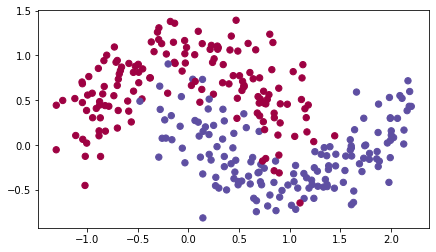

In [29]:
train_X, train_Y = func_load_dataset()

### overwrite dnn model
用以下三种方式：
- Mini-batch **Gradient Descent**: it will call your function:
    - `update_parameters_with_gd()`
- Mini-batch **Momentum**: it will call your functions:
    - `initialize_velocity()` and `update_parameters_with_momentum()`
- Mini-batch **Adam**: it will call your functions:
    - `initialize_adam()` and `update_parameters_with_adam()`

In [30]:
def func_L_layer_dnn_model(X, Y, layer_dims, optimizer, lr=0.0007, mini_batch_size=64, beta=0.9,
                           beta1=0.9, beta2=0.999, epsilon=1e-8, num_epochs=10000, print_cost=True):
    """
    多层神经网络模型
    Arguments:
    X -- input data, of shape (2, number of examples)
    Y -- true "label" vector (1 for blue dot / 0 for red dot), of shape (1, number of examples)
    layers_dims -- python list, containing the size of each layer
    learning_rate -- the learning rate, scalar.
    mini_batch_size -- the size of a mini batch
    beta -- Momentum hyperparameter
    beta1 -- Exponential decay hyperparameter for the past gradients estimates 
    beta2 -- Exponential decay hyperparameter for the past squared gradients estimates 
    epsilon -- hyperparameter preventing division by zero in Adam updates
    num_epochs -- number of epochs
    print_cost -- True to print the cost every 1000 epochs

    Returns:
    parameters -- python dictionary containing your updated parameters 
    """
    seed = 10
#     np.random.seed(seed)
    L = len(layer_dims)
    t = 0
    costs = []
#     m = X.shape[1]
    
    # 参数初始化
    parameters = func_L_layers_initialize_parameters(layer_dims, seed=3)
    
    # initialize the optimizer
    if optimizer == 'gd':
        pass
    elif optimizer == 'momentum':
        v = func_initialize_velocity(parameters)
    elif optimizer == 'adam':
        v, s = func_initialize_adam(parameters)
    else:
        raise ValueError('error optimizer setting!')
    
    # loop
    for epoch in range(num_epochs):
        
        # 每个epoch随机生成minibatch
        seed += 1
        mini_batches = func_random_mini_batches(X, Y, mini_batch_size, seed)
        
        for mini_batch in mini_batches:
            (mini_batch_X, mini_batch_Y) = mini_batch
        
            # 前向传播
            AL, caches = func_L_model_forward(mini_batch_X, parameters)

            # 计算损失
            cost = func_compute_cost(AL, mini_batch_Y)

            # 后向传播
            grads = func_L_model_backward(AL, mini_batch_Y, caches)

            # 更新参数
            if optimizer == 'gd':
                parameters = func_update_parameters(parameters, grads, lr)
            elif optimizer == 'momentum':
                parameters, v = func_update_parameters_with_momentum(parameters, grads, v, beta, lr)
            elif optimizer == 'adam':
                t += 1
                parameters, v, s = func_update_parameters_with_adam(parameters, grads, v, s, t, lr, beta1, beta2, epsilon)
        
        # 打印信息
        if print_cost and epoch % 1000 == 0:
            print('cost after epoch {}: {}'.format(epoch, np.squeeze(cost)))
        if epoch % 100 == 0:
            costs.append(cost)
    
    return parameters, costs

### mini-batch gradient descent

In [31]:
layer_dims = [train_X.shape[0], 5, 2, 1]
lr=0.0007

cost after epoch 0: 0.6907355122911127
cost after epoch 1000: 0.6852725328458241
cost after epoch 2000: 0.6470722240719001
cost after epoch 3000: 0.6195245549970403
cost after epoch 4000: 0.5765844355950943
cost after epoch 5000: 0.6072426395968578
cost after epoch 6000: 0.5294033317684573
cost after epoch 7000: 0.4607682398593011
cost after epoch 8000: 0.465586082399045
cost after epoch 9000: 0.46451797221676827


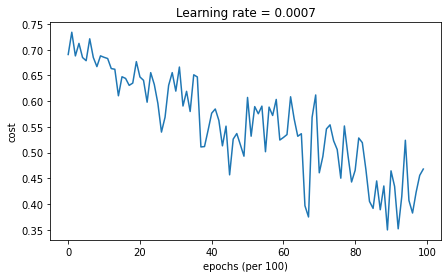

In [32]:
parameters, costs = func_L_layer_dnn_model(train_X, train_Y, layer_dims, optimizer='gd', lr=lr)
func_plot_cost(costs, lr=lr)

acc: 0.7966666666666666


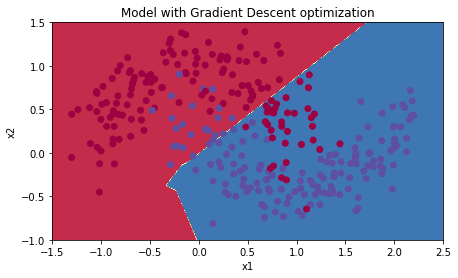

In [33]:
pred = func_predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with Gradient Descent optimization")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
func_plot_decision_boundary(lambda x: func_predict_dec(parameters, x.T), train_X, train_Y)

### mini-batch gradient descent with momentum

In [34]:
layer_dims = [train_X.shape[0], 5, 2, 1]
lr=0.0007

cost after epoch 0: 0.6907412988351506
cost after epoch 1000: 0.6853405261267576
cost after epoch 2000: 0.6471448370095255
cost after epoch 3000: 0.6195943032076023
cost after epoch 4000: 0.576665034407302
cost after epoch 5000: 0.607323821900647
cost after epoch 6000: 0.5294761758786997
cost after epoch 7000: 0.46093619004872377
cost after epoch 8000: 0.4657800937012721
cost after epoch 9000: 0.4647395967922749


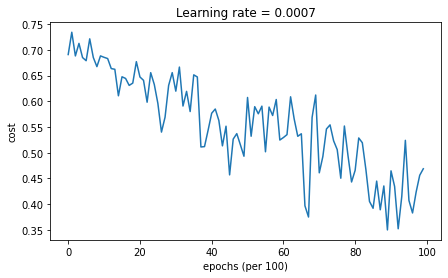

In [35]:
parameters, costs = func_L_layer_dnn_model(train_X, train_Y, layer_dims, optimizer='momentum', lr=lr)
func_plot_cost(costs, lr=lr)

acc: 0.7966666666666666


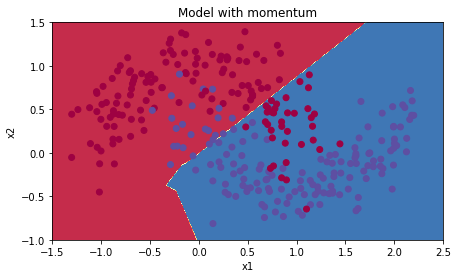

In [36]:
pred = func_predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with momentum")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
func_plot_decision_boundary(lambda x: func_predict_dec(parameters, x.T), train_X, train_Y)

### mini-batch with adam

In [37]:
layer_dims = [train_X.shape[0], 5, 2, 1]
lr=0.0007

cost after epoch 0: 0.6905522282919487
cost after epoch 1000: 0.1855671862856554
cost after epoch 2000: 0.15085206145242497
cost after epoch 3000: 0.0744535775981412
cost after epoch 4000: 0.1259357502178564
cost after epoch 5000: 0.10423511812705896
cost after epoch 6000: 0.10055245705694958
cost after epoch 7000: 0.031601421955873635
cost after epoch 8000: 0.11170898323416338
cost after epoch 9000: 0.19764808192436198


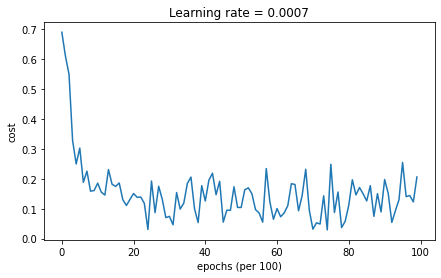

In [38]:
parameters, costs = func_L_layer_dnn_model(train_X, train_Y, layer_dims, optimizer='adam', lr=lr)
func_plot_cost(costs, lr=lr)

acc: 0.94


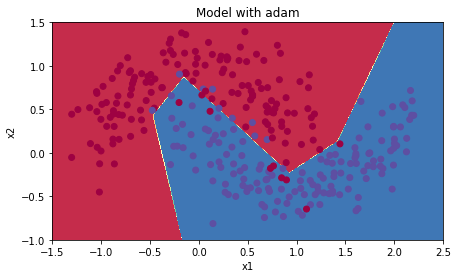

In [39]:
pred = func_predict(train_X, train_Y, parameters)

# Plot decision boundary
plt.title("Model with adam")
axes = plt.gca()
axes.set_xlim([-1.5,2.5])
axes.set_ylim([-1,1.5])
func_plot_decision_boundary(lambda x: func_predict_dec(parameters, x.T), train_X, train_Y)

## 总结

1. momentum是有效的，但是对较小的lr和小数据集，影响甚微
2. adam收敛更快，通常表现很好（不怎么调参（除了lr）的情况下）